In [1]:
import igl
import math
import scipy as sp
import numpy as np
import meshplot as mp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial as sp_spatial
import numba
import os
root_folder = os.getcwd()

In [2]:
# v_init, f = igl.read_triangle_mesh(os.path.join(root_folder, "Oblate_Coarse.off"))
#v1, f1 = igl.read_triangle_mesh(os.path.join(root_folder, "Oblate_Finer.off"))
### Parameters for running computation
global Kb
global Kv
global Ka
global gamma
global KbT
global delT
global Kal
Kal=1
Ka=2
Kv=1
Kb=0.01
H0=0
Volume_t= 0.90* 3.14 * 4 / 3
Area_t=4*3.14
KbT=0.01
charTimeStep=0.1
isAdaptiveStep=False
#hdt=0.5*dt
iterations = 3000
outfrequency = 50
tolerance = 1e-3
maxError = 5000

#v_init,f=igl.upsample(v1,f1,1)
gamma=4#*(len(v1)/len(v_init))

#max(v1[:,2])
rp=0.161  ###radius of nanoparticle
####center of radious 
x=1.161
y=0
z=0
rho=0.1 ### Potential Range Distance
u=2.4
U=(Kb*u)/((rp)**2)

###rp diameter of particle


In [3]:
import meshzoo
import optimesh
points,cells = meshzoo.tetra_sphere(20)

class Sphere:
    def f(self, x):
        return 1.0 - (x[0] ** 2 + x[1] ** 2 + x[2] ** 2)

    def grad(self, x):
        return -2 * x
v_init, f= optimesh.optimize_points_cells(
    points,cells,"CVT (full)",1.0e-2,100,verbose=False,implicit_surface=Sphere(),
    # step_filename_format="out{:03d}.vtk"
)

len(v_init)


802

In [4]:
###Energy Calculations /// Area+Bending+Volume
# @numba.jit
def Energy_area(v,f,Area_t):
    Area_new=cal_areatot(v,f)
    Energy_Area=Ka*((Area_new-Area_t)**2)/Area_t
    return Energy_Area
# @numba.jit
def Energy_volume(v,f,Volume_t):
    volume_new=cal_volumetot(v,f)
    Energy_volume=Kv*((volume_new-Volume_t)**2)/Volume_t
    return Energy_volume  

In [5]:
def adjacent_face(v,f):
    df=pd.DataFrame(f,columns=list('ABC'))
    row_numbers=[]
    for i in range(len(v)):
        row_numbers.append((df.index[(df['A'] == i)|(df['B'] == i) | (df['C'] == i)].tolist()))
    return row_numbers
def cal_areatot(v,f):
    dbl_area = igl.doublearea(v, f)    
    Areatot = np.sum(dbl_area)/2
    return Areatot
@numba.jit
def cal_volumetot(v,f):
    Volumetot = 0
    for i in range(len(f)):
        sum=0
        p0x=v[f[i][0]][0]
        p0y=v[f[i][0]][1]
        p0z=v[f[i][0]][2]
        p1x=v[f[i][1]][0]
        p1y=v[f[i][1]][1]
        p1z=v[f[i][1]][2]
        p2x=v[f[i][2]][0]
        p2y=v[f[i][2]][1]
        p2z=v[f[i][2]][2]
        v321= p2x*p1y*p0z
        v231= p1x*p2y*p0z
        v312= p2x*p0y*p1z
        v132= p0x*p2y*p1z
        v213= p1x*p0y*p2z
        v123= p0x*p1y*p2z
        sum=(-v321+ v231+ v312-v132-v213+ v123) / 6.0
        #print(sum)
        Volumetot+=sum
    return Volumetot

def areaGrad(v,f):
    #n=igl.per_vertex_normals(v,f) ## not using per_vertex_normals for areaGrad direction
    l = igl.cotmatrix(v, f) ###laplacian-operator
    ag = -l.dot(v)
    return ag
def volGrad(v,f):
    npv = igl.per_vertex_normals(v, f)
    face_normal=igl.per_face_normals(v,f,npv)
    dbl_area = igl.doublearea(v, f)
    adjacent_vertices=igl.adjacency_list(f)
    adjacent_faces=adjacent_face(v,f)
    volumegrad=[]
    for i in range(len(v)):
        vol_ij=0
        for j in range(len(adjacent_faces[i])):
            k=adjacent_faces[i][j]
            Area=dbl_area[k]/2
            FaceNorm=face_normal[k]
            vol_ij += (1/3)*Area*FaceNorm
        volumegrad.append(vol_ij)
    return np.array(volumegrad)
def ver_new(v,f):
    adjacent_faces=adjacent_face(v,f)
    Area=igl.doublearea(v,f)
    n = igl.per_vertex_normals(v, f)
    face_normal=igl.per_face_normals(v,f,n)
    v_b=igl.barycenter(v,f)
    v_new=[]
    for i in range(len(v)):
        face_area=Area[adjacent_faces[i]]
        face_area_sum=np.sum(face_area)
        v_centroid=v_b[adjacent_faces[i]]
        sum_of_area_centroid=np.dot(face_area,v_centroid)
        v_avg=sum_of_area_centroid/face_area_sum
        fnorm=face_normal[adjacent_faces[i]]
        fsum=np.sum(fnorm,axis=0)
        lamda=(np.dot(v_avg,fsum)-np.dot(v[i],fsum))/np.dot(fsum,fsum)
        v_new.append(v_avg-lamda*fsum)    
    return np.array(v_new)

In [6]:
###Force  and Energy Calculations from bending

def Force_Bending(v,f):
    npv = igl.per_vertex_normals(v, f)
    K = igl.gaussian_curvature(v, f)
    l = igl.cotmatrix(v, f) ###laplacian-operator
    m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
    area_voronoi=m.diagonal()
    minv = sp.sparse.diags(1 / m.diagonal())
    Hn = -minv.dot(l.dot(v))/2
    H_mean = np.linalg.norm(Hn, axis=1)
    sign_H = np.sign(np.sum(Hn*npv, axis=1))
    #if (min(sign_H)<0):
    #    print('H_mean changes sign')
    H_mean_signed = H_mean*sign_H
    Lap_H = minv.dot(l.dot(H_mean_signed-H0))
    kn = minv.dot(K)
    first_term = 2*(H_mean_signed-H0)*(H_mean_signed**2 + H0*H_mean_signed -kn)
    totalforce = first_term + Lap_H
    #for i in range (len(v)):
    Force_bending = 2*Kb*npv*totalforce[:,None]*area_voronoi[:,None]
    Eb = 2*Kb*(((H_mean_signed-H0)**2))*area_voronoi
    total_EB = np.sum(Eb)
    
    return Force_bending,total_EB

In [7]:
###Force from Area Constraints
@numba.jit
def Force_Area(Area_t,grad_Area,Area_new):
    Force_Area=-2*(Ka)*((Area_new-Area_t)/Area_t)*grad_Area
    ## Area constraint is not the same as in mem3dg
    return Force_Area

In [8]:
###Force from Volume Area Constraints
@numba.jit
def Force_Volume(Volume_t,grad_Volume,volume_new):
    Force_Volume=-2*(Kv)*((volume_new-Volume_t)/Volume_t)*grad_Volume 
    ## Volume constraint is not the same as in mem3dg
    return Force_Volume

In [9]:
# Calculation of Adhersive Forces_____Heavyside Function 
# def Force_Adhersive(points,cells,x,y,z,dc,U,AG):
#     distance=np.zeros(len(points))
#     coef=np.zeros(len(points))

#     for i in range(len(points)):
#         distance[i]=(np.sqrt((((points[i][0])-x)**2)+(((points[i][1])-y)**2)+(((points[i][2])-z)**2)))
#         if (distance[i]-rp)>dc:
#             coef[i]=0
#         else:
#             coef[i]=U
#     Fad=coef[:,None]*AG
#     return Fad

### With Morse Potenitial
# def Force_Adhersive(v,f,x,y,z,rho,U,AG):
#     distance=np.zeros(len(v))
#     coef=np.zeros(len(v))
#     dc=np.zeros(len(v))
#     for i in range(len(v)):
#         distance[i]=(np.sqrt((((v[i][0])-x)**2)+(((v[i][1])-y)**2)+(((v[i][2])-z)**2)))
#         dc[i]=distance[i]-(rp)
#         coef[i]=U*(np.exp(-(2*dc[i])/rho) - 2*np.exp(-dc[i]/rho))
# #     m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
# #     area_voronoi=m.diagonal()
# #     Energy_adhesive=np.dot(coef,area_voronoi)
# #     Ead = np.sum(Energy_adhesive)
#     Fad=-coef[:,None]*AG  ###Negative sign for negative gradient
#     return Fad #,Ead

tol = 1e-10
def Force_Adhersive(v, f, x, y, z, rho, U, AG):
    distance = np.zeros(len(v))
    coef = np.zeros(len(v))
    dc = np.zeros(len(v))
    coefficinet_derivative_x = np.zeros(len(v))
    coefficinet_derivative_y = np.zeros(len(v))
    coefficinet_derivative_z = np.zeros(len(v))

    for i in range(len(v)):
        distance[i] = (np.sqrt((((v[i][0])-x)**2) +
                       (((v[i][1])-y)**2)+(((v[i][2])-z)**2)))
        dc[i] = distance[i]-(rp)
        tol = 1e-20
        coef[i] = U*(np.exp(-(2*dc[i])/rho) - 2*np.exp(-dc[i]/rho))
        if abs(coef[i]) < tol:
            coef[i] = 0

        coefficinet_derivative_x[i] = (
            U/(distance[i]*rho))*(-np.exp(-(2*dc[i])/rho) + 2*np.exp(-dc[i]/rho)) * 2 * (v[i][0]-x)
        coefficinet_derivative_y[i] = (
            U/(distance[i]*rho))*(-np.exp(-(2*dc[i])/rho) + 2*np.exp(-dc[i]/rho)) * 2 * (v[i][1]-y)
        coefficinet_derivative_z[i] = (
            U/(distance[i]*rho))*(-np.exp(-(2*dc[i])/rho) + 2*np.exp(-dc[i]/rho)) * 2 * (v[i][2]-z)
        if abs(coefficinet_derivative_x[i]) < tol:
            coefficinet_derivative_x[i] = 0
        if abs(coefficinet_derivative_y[i]) < tol:
            coefficinet_derivative_y[i] = 0
        if abs(coefficinet_derivative_z[i]) < tol:
            coefficinet_derivative_z[i] = 0

    coefficinet_derivative = np.array(
        [coefficinet_derivative_x, coefficinet_derivative_y, coefficinet_derivative_z]).T
    m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
    area_voronoi = m.diagonal()
    First_Term = coef[:, None]*AG
    Second_Term = area_voronoi[:, None]*coefficinet_derivative
    Fad = (-First_Term - Second_Term)

    return Fad    
 

In [10]:
def Total_Force(FB,FA,FV,Fad):
    Total_force=(FB+FA+FV+Fad)
    return Total_force

In [11]:
def updateTimeStep(v,f,l,TF,initialMaxForce,dt_size2_ratio,charTimeStep):
    currentMinSize = np.amin(l)
    currentMaxForce = np.amax(np.linalg.norm(TF, axis=1))
    dt = (dt_size2_ratio * currentMinSize **2)*\
        (initialMaxForce / currentMaxForce)
    
    if (charTimeStep / dt > 1e3):
        print("Time step too small! May consider restarting\n",
              "simulation in small time scale")
        print("Current size / initial size =",
              currentMinSize /np.sqrt(charTimeStep/dt_size2_ratio))
        print("Current forece / inital force =",
             currentMaxForce / initialMaxForce)
        exit()
    return dt

In [12]:
### main loop for simulation
l = igl.edge_lengths(v_init,f)
l0 = igl.avg_edge_length(v_init,f)
dt_size2_ratio = charTimeStep / np.amin(l)**2
number_of_vertices=len(v_init)
###Forward Euler Main 
#Setup

v=v_init
vel=np.zeros((len(v_init),3))
time=0
#FD=fun_FD2(v_init,f,vel)

#Volume_old=cal_volume(v,f)
#Area_t=cal_Area(v,f)
grad_Area=areaGrad(v_init,f)
grad_Volume=volGrad(v_init,f)
Area_new=cal_areatot(v_init,f)
print('initial area = ',Area_new)
Volume_new=cal_volumetot(v_init,f)
print('initial volume = ', Volume_new)

FB,EB=Force_Bending(v_init,f)
FA=Force_Area(Area_t,grad_Area,Area_new)
FV=Force_Volume(Volume_t,grad_Volume,Volume_new)
Fad=Force_Adhersive(v_init,f,x,y,z,rho,U,grad_Area)
#FR=0*Force_Random(v,f,charTimeStep)
TF=Total_Force(FB,FA,FV,Fad)
initialMaxForce = np.amax(np.linalg.norm(TF, axis=1))

### Calculation of Energy
timeout=[]
totalEnergy=[]
EnergyArea=[]
EnergyVolume=[]
EnergyBending=[]
EnergyAdhesive=[]

for i in range(iterations):
    #Integration
    
    vel = TF/gamma
    
    ## adjust time step if adopt adaptive time step based on mesh size
    if (isAdaptiveStep):
        charTimeStep = updateTimeStep(v,f,l,TF,initialMaxForce,
                                                dt_size2_ratio,charTimeStep);
        
    dt = charTimeStep
    
    v += vel*dt
    time += dt
    
    ###Mesh Regularization
    l = igl.edge_lengths(v,f)
    v=ver_new(v,f)
    if (not igl.is_intrinsic_delaunay(l,f).all()):
        #v,f,_=pymesh.split_long_edges_raw(v,f,l0*4/3)
        print('time =',time,': not all edges are delaunay, call intrinsic delaunay triangulation')
        l, f= igl.intrinsic_delaunay_triangulation(l,f)
   
    #Force calculation
    Area_current=cal_areatot(v,f)
    grad_Area_new=areaGrad(v,f)
    Volume_current=cal_volumetot(v,f)
    grad_Volume_new=volGrad(v,f)
    ###Update forces here
 
    FB,EB=Force_Bending(v,f) ##bending_force and Bending Energy
    FA=Force_Area(Area_t,grad_Area_new,Area_current)
    FV=Force_Volume(Volume_t,grad_Volume_new,Volume_current)
    Fad=Force_Adhersive(v,f,x,y,z,rho,U,grad_Area_new)

    TF=Total_Force(FB,FA,FV,Fad)

    
    mechErrorNorm = np.sum(np.linalg.norm(TF, axis=1))

    if i%outfrequency==0:
        print('time =',time)
        print('dt =',dt)
        print('dVolume/Volume_t =',Volume_current-Volume_t,'/',Volume_t)
        print('dArea/Area_t =',Area_current-Area_t,'/',Area_t)
        print('mechErrorNorm =',mechErrorNorm)
        timeout.append(time)
        EnergyArea.append(Energy_area(v,f,Area_t))
        EnergyVolume.append(Energy_volume(v,f,Volume_t))
        EnergyBending.append(EB)
        PotentialEnergy = np.array(EnergyArea) + np.array(EnergyVolume) + np.array(EnergyBending)
        
        print('PE = ',PotentialEnergy[-1])
#         mp.jupyter()
#         p=mp.plot(v,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
#                                "width": 300, "height": 300},return_plot=True)
#         #p.add_lines(v,v+1*FB, shading={"line_color": "red"})
        name = 'test'+str(i)
        print('number of vertices=',len(v))
        print('number of Iterations=',i)
    if i>=100 and i%outfrequency==0:
        EnergyChangeRate=(abs(PotentialEnergy[-1]-PotentialEnergy[-2])/(PotentialEnergy[-1]))*100
        print('Energy_Change_Rate =', EnergyChangeRate)
    if i>=100 and EnergyChangeRate<tolerance:
        print('Change of Energy is very small \n Reached Equilibrioum Shape')
#         igl.write_triangle_mesh(os.path.join(root_folder,'08_23_2022/',filename), v, f)
        np.savetxt(os.path.join('08_23_22',"PE_u=4,rho=5.txt"), (PotentialEnergy))
        np.savetxt(os.path.join('08_23_22',"BE_u=4,rho=5.txt"), (EnergyBending))
        print('Storing Off file')
        break

initial area =  12.515811310550506
initial volume =  4.157502112355637
time = 0.1
dt = 0.1
dVolume/Volume_t = 0.3894169245776644 / 3.7680000000000002
dArea/Area_t = -0.04474972456426052 / 12.56
mechErrorNorm = 6.36404813178312
PE =  0.29093303359516
number of vertices= 802
number of Iterations= 0
time = 5.099999999999998
dt = 0.1
dVolume/Volume_t = 0.36914703147792904 / 3.7680000000000002
dArea/Area_t = -0.06623651105793016 / 12.56
mechErrorNorm = 6.8145092407036865
PE =  0.2970230033694979
number of vertices= 802
number of Iterations= 50
time = 10.09999999999998
dt = 0.1
dVolume/Volume_t = 0.344867432348813 / 3.7680000000000002
dArea/Area_t = -0.10696699900036144 / 12.56
mechErrorNorm = 6.627800218992058
PE =  0.2957463884108592
number of vertices= 802
number of Iterations= 100
Energy_Change_Rate = 0.43165868076981156
time = 15.099999999999962
dt = 0.1
dVolume/Volume_t = 0.3259027094658111 / 3.7680000000000002
dArea/Area_t = -0.14130566273629874 / 12.56
mechErrorNorm = 6.3698421389699

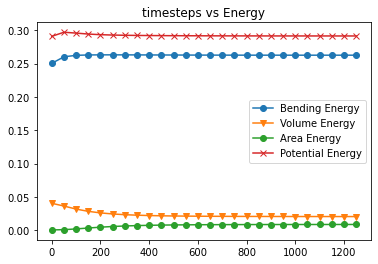

In [13]:
time=np.linspace(0,i,len(EnergyBending))
# plt.plot(time,totalEnergy,'o-', color='red', label='total Energy')
plt.plot(time,EnergyBending,'o-', label='Bending Energy')
plt.plot(time,EnergyVolume,'v-', label='Volume Energy')
plt.plot(time,EnergyArea,'o-', label='Area Energy')
plt.plot(time,PotentialEnergy,'x-',label='Potential Energy')
# plt.plot(time,KineticEnergy,'v-', label='Kinetic Energy',color='k')
#plt.axis([0, 800, 0, 2])
plt.legend(loc='right')
plt.title('timesteps vs Energy')
plt.show()

<Figure size 432x288 with 0 Axes>

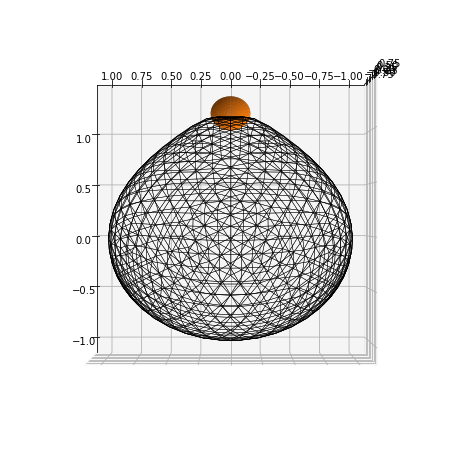

In [14]:
fig = plt.figure()

fig = plt.figure(figsize =(14, 8))
ax = plt.axes(projection ='3d')
surf=ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, edgecolor=[[0,0,0]], linewidth=0.4, alpha=0.0, shade=False)
#ax.plot_surface(x, y, z)
rp =0.161
u, v1 = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = (rp*(np.cos(u) * np.sin(v1)))+1.161
y = (rp*(np.sin(u) * np.sin(v1)))
z = (rp*(np.cos(v1)))
surf=ax.plot_surface(x, y, z)
ax.view_init(90,180)
plt.show()

In [15]:
# npv = igl.per_vertex_normals(v, f)
# K = igl.gaussian_curvature(v, f)
# m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
# minv = sp.sparse.diags(1 / m.diagonal())
# area_voronoi=m.diagonal()
# l = igl.cotmatrix(v, f) ###laplacian-operator
# m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
# minv = sp.sparse.diags(1 / m.diagonal())
# Hn = -minv.dot(l.dot(v))/2
# H_mean = np.linalg.norm(Hn, axis=1)
# sign_H = np.sign(np.sum(Hn*npv, axis=1))
# H_mean.shape
# import polyscope as ps

# # Initialize polyscope
# ps.init()

# ### Register a point cloud
# # # `my_points` is a Nx3 numpy array
# # p=ps.register_point_cloud("my points", v)

# ### Register a mesh
# # `verts` is a Nx3 numpy array of vertex positions
# # `faces` is a Fx3 array of indices, or a nested list
# ps.register_surface_mesh("my mesh", v, f, smooth_shade=True)

# # Add a scalar function and a vector function defined on the mesh
# # vertex_scalar is a length V numpy array of values
# # face_vectors is an Fx3 array of vectors per face
# ps.get_surface_mesh("my mesh").add_scalar_quantity("my_scalar", 
#                    H_mean, defined_on='vertices', cmap='jet')
# # p.add_scalar_quantity("rand vals with range", H_mean, vminmax=(-5., 5.), enabled=True)

# # p.add_scalar_quantity("rand vals with range", H_mean, cmap='jet',enabled=True)

# # ps.get_surface_mesh("my mesh").add_vector_quantity("my_vector", 
# #         face_vectors, defined_on='faces', color=(0.2, 0.5, 0.5))

# # View the point cloud and mesh we just registered in the 3D UI
# ps.show()

In [16]:
# igl.write_triangle_mesh(os.path.join(root_folder,'08_15_2022/',"u=4,rho=1.off"), v, f)
# np.savetxt(os.path.join('08_15_2022/',"PE_u=4_rho=1.txt"), (PotentialEnergy))
# np.savetxt(os.path.join('08_15_2022/',"BE_u=4_rho=1.txt"), (EnergyBending))

In [17]:
mp.jupyter()
p=mp.plot(v,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
                       "width": 300, "height": 300},return_plot=True)
# p.save("u=2,rho=4.html")
#p.add_lines(v,v+1*FB, shading={"line_color": "red"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0720745…

igl.write_triangle_mesh(os.path.join(root_folder,'08_23_22',"u=4,rho=5.off"), v, f)
np.savetxt(os.path.join('08_23_22/',"PE_u=4,rho=5.txt"), (PotentialEnergy))
np.savetxt(os.path.join('08_23_22/',"BE_u=4,rho=5.txt"), (EnergyBending))